
Label distribution in the dataset:
label
N    5050
O    2456
A     738
~     284
Name: count, dtype: int64


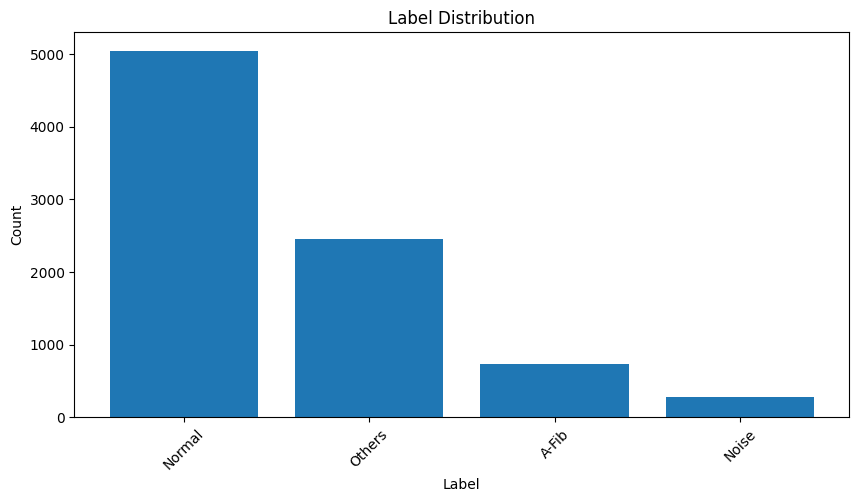

In [1]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the directory where your PhysioNet data is stored
data_path = "data/training2017"

# Read the reference file (contains labels)
labels_df = pd.read_csv(f'{data_path}/REFERENCE.csv', header=None, names=['record_name', 'label'])

# Print label distribution
labels = labels_df.label.value_counts()
print("\nLabel distribution in the dataset:")
print(labels)

# plot the label distribution
plt.figure(figsize=(10, 5))
plt.bar(labels.index, labels.values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(labels.index, ['Normal', 'Others', 'A-Fib', 'Noise'], rotation=45)
plt.show()


In [4]:
def plot_ecg_record(record_name, data_path, labels_df):
    # Read the record
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    annotation = wfdb.rdann(f'{data_path}/{record_name}', 'atr', sampfrom=180, sampto=4000,shift_samps=True)
    signals = record.p_signal
    
    # Get the label for this record
    label = labels_df[labels_df.record_name == record_name].label.values[0]
    
    # Print record information
    print(f"Record: {record_name}")
    print(f"Label: {label}")
    print(f"Signal shape: {signals.shape}")
    print("\nFirst few samples:")
    print(signals[:5])
    
    # Plot the signal
    plt.figure(figsize=(15, 5))
    plt.plot(signals)
    plt.title(f'ECG Signal - Record {record_name} (Class: {label})')
    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    
    return signals  # Optional: return the signals if needed for further processing

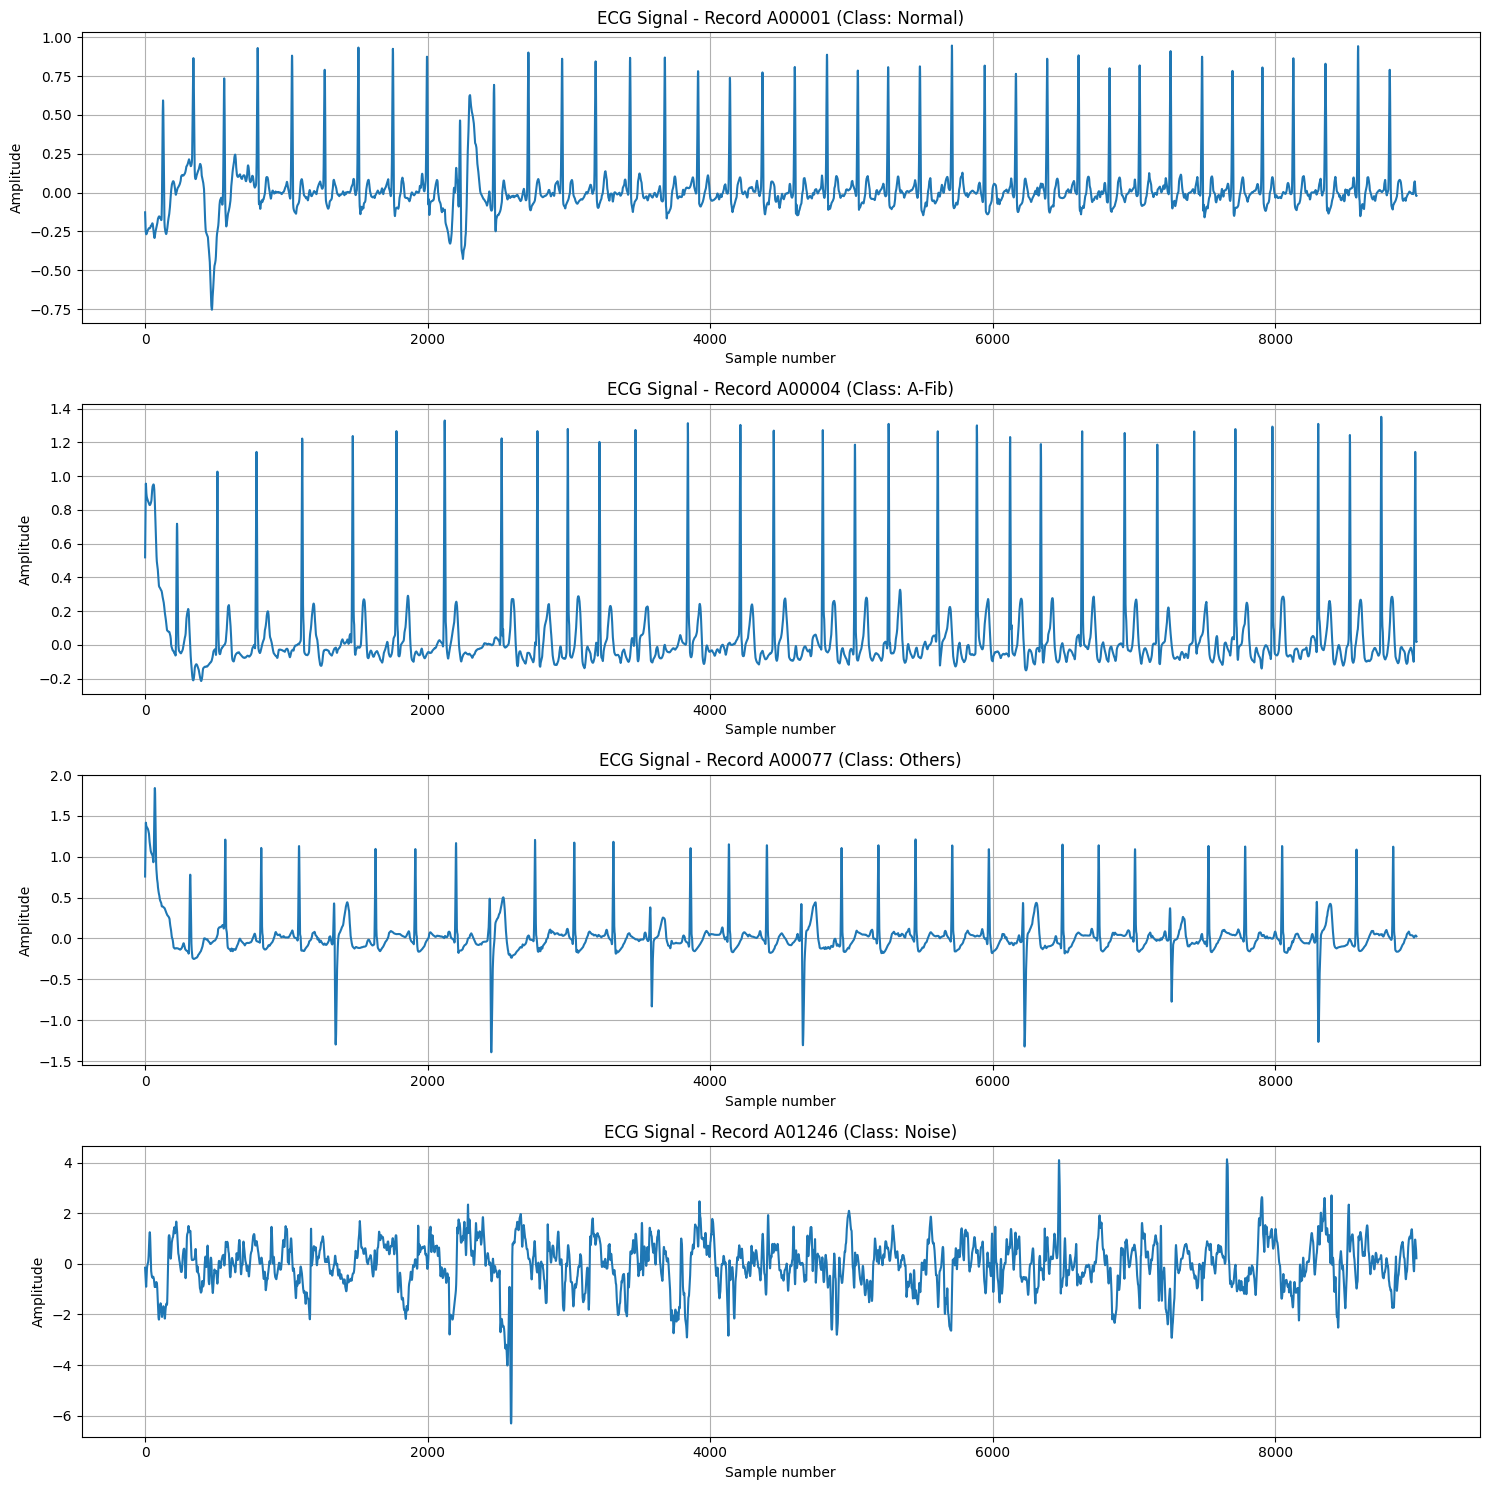

In [3]:
# Plot multiple records vertically
record_ids = ['A00001', 'A00004', 'A00077', 'A01246']
labels = {'N': 'Normal', 'O': 'Others', 'A': 'A-Fib', '~': 'Noise'}

plt.figure(figsize=(15, 15))  # Adjusted figure size for vertical layout
for i, record_id in enumerate(record_ids, 1):
    plt.subplot(4, 1, i)  # Changed to 4 rows, 1 column
    record = wfdb.rdrecord(f'{data_path}/{record_id}')
    signals = record.p_signal
    label = labels_df[labels_df.record_name == record_id].label.values[0]
    
    plt.plot(signals)
    plt.title(f'ECG Signal - Record {record_id} (Class: {labels[label]})')
    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
def analyze_record(record_name, data_path, labels_df):
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()  # Flatten in case it's 2D
    label = labels_df[labels_df.record_name == record_name].label.values[0]
    
    # Center the signal by subtracting the mean
    centered_signals = signals - np.mean(signals)
    
    # Count zero crossings (both positive->negative and negative->positive)
    zero_crossings = np.sum(np.abs(np.diff(np.signbit(centered_signals))))
    
    stats = {
        'mean': np.mean(signals),
        'std': np.std(signals),
        'min': np.min(signals),
        'max': np.max(signals),
        'range': np.ptp(signals),
        'length': len(signals),
        'zero_crossings': zero_crossings,  # Now using the correct calculation
        'energy': np.sum(signals**2),
        'rms': np.sqrt(np.mean(signals**2)),
        'label': label
    }
    
    return stats


In [5]:

# Analyze multiple records
record_ids = ['A00001', 'A00004', 'A00077', 'A01246']
results = []

for record_id in record_ids:
    stats = analyze_record(record_id, data_path, labels_df)
    stats['record_id'] = record_id
    results.append(stats)

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nSignal Analysis Results:")
print(results_df)


Signal Analysis Results:
       mean       std    min    max   range  length  zero_crossings  \
0  0.018569  0.168318 -0.754  0.946   1.700    9000             248   
1  0.040544  0.213619 -0.214  1.352   1.566    9000             145   
2  0.022840  0.240672 -1.393  1.841   3.234    9000             180   
3 -0.018756  0.959795 -6.311  4.131  10.442    9000             275   

        energy       rms label record_id  
0   258.081903  0.169339     N    A00001  
1   425.494164  0.217433     A    A00004  
2   526.001866  0.241753     O    A00077  
3  8294.029190  0.959979     ~    A01246  



Record A00001 (Label: N)
Dominant frequency: 3.77 Hz
Top 5 frequency components:
  3.77 Hz (magnitude: 149.84)
  4.03 Hz (magnitude: 140.81)
  2.73 Hz (magnitude: 139.91)
  2.50 Hz (magnitude: 136.06)
  4.07 Hz (magnitude: 135.93)

Record A00004 (Label: A)
Dominant frequency: 1.13 Hz
Top 5 frequency components:
  1.13 Hz (magnitude: 268.70)
  0.87 Hz (magnitude: 247.67)
  3.97 Hz (magnitude: 195.28)
  4.13 Hz (magnitude: 189.61)
  1.00 Hz (magnitude: 156.42)

Record A00077 (Label: O)
Dominant frequency: 1.33 Hz
Top 5 frequency components:
  1.33 Hz (magnitude: 195.92)
  1.90 Hz (magnitude: 187.95)
  1.73 Hz (magnitude: 181.33)
  0.83 Hz (magnitude: 179.49)
  0.87 Hz (magnitude: 178.50)

Record A01246 (Label: ~)
Dominant frequency: 0.90 Hz
Top 5 frequency components:
  0.90 Hz (magnitude: 1586.90)
  0.77 Hz (magnitude: 1406.70)
  0.97 Hz (magnitude: 1203.87)
  1.00 Hz (magnitude: 1076.19)
  0.70 Hz (magnitude: 1049.89)


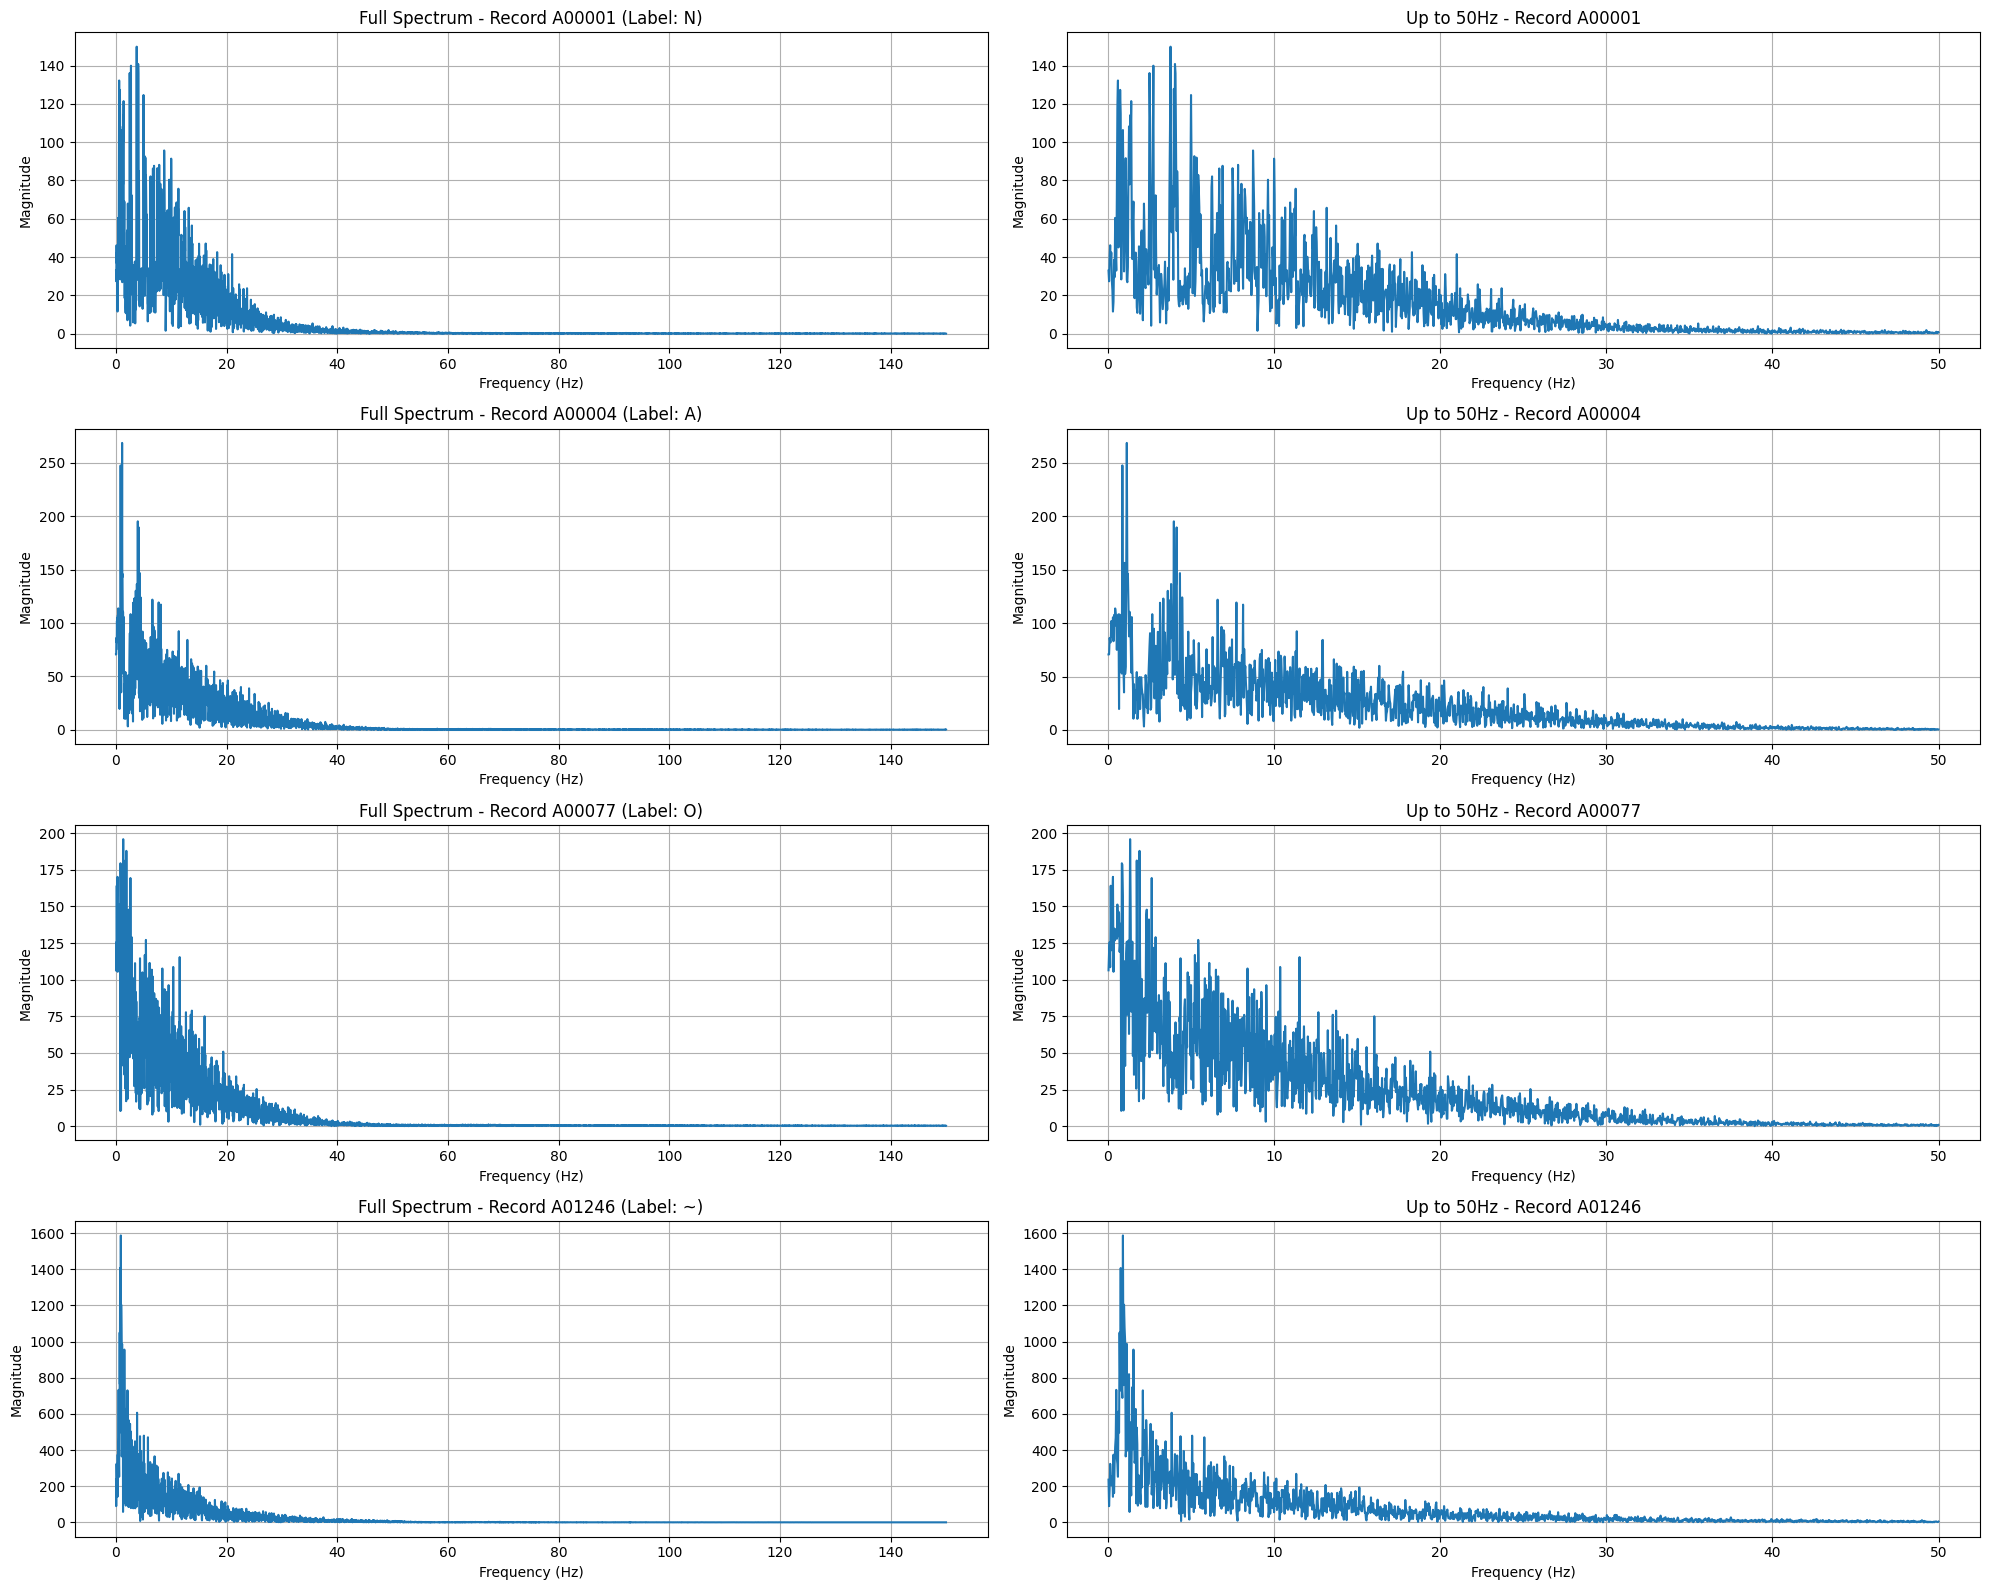


Frequency Analysis Results:
   dominant_freq label                                        top_5_freqs  \
0       3.766667     N  [4.0666666666666655, 2.4999999999999996, 2.733...   
1       1.133333     A  [0.9999999999999998, 4.133333333333333, 3.9666...   
2       1.333333     O  [0.8666666666666665, 0.8333333333333331, 1.733...   
3       0.900000     ~  [0.6999999999999998, 0.9999999999999998, 0.966...   

                                    top_5_magnitudes record_id  
0  [135.92546042585946, 136.06082372580588, 139.9...    A00001  
1  [156.4164101308666, 189.6148559582695, 195.280...    A00004  
2  [178.5005705755114, 179.49257852838164, 181.32...    A00077  
3  [1049.8880183885963, 1076.1857175028358, 1203....    A01246  


In [6]:
def analyze_frequency(record_name, data_path, labels_df, ax1, ax2):
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()
    label = labels_df[labels_df.record_name == record_name].label.values[0]
    
    # Perform FFT
    sampling_rate = 300  # Hz (typical for this dataset)
    n = len(signals)
    fft_result = np.fft.fft(signals)
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    
    # Get positive frequencies only (first half)
    pos_freqs = freqs[:n//2]
    pos_fft = np.abs(fft_result)[:n//2]
    
    # Find dominant frequency (excluding DC component)
    dominant_freq_idx = np.argmax(pos_fft[1:]) + 1  # Skip first element (DC)
    dominant_freq = pos_freqs[dominant_freq_idx]
    
    print(f"\nRecord {record_name} (Label: {label})")
    print(f"Dominant frequency: {dominant_freq:.2f} Hz")
    print(f"Top 5 frequency components:")
    top_5_idx = np.argsort(pos_fft[1:])[-5:] + 1
    for idx in reversed(top_5_idx):
        print(f"  {pos_freqs[idx]:.2f} Hz (magnitude: {pos_fft[idx]:.2f})")
    
    # Plot frequency spectrum using provided axes
    # Plot 1: Full spectrum
    ax1.plot(pos_freqs[1:], pos_fft[1:])  # Skip DC component
    ax1.set_title(f'Full Spectrum - Record {record_name} (Label: {label})')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Magnitude')
    ax1.grid(True)
    
    # Plot 2: Zoomed in to lower frequencies
    max_freq = 50  # Show only up to 50 Hz
    freq_mask = pos_freqs <= max_freq
    ax2.plot(pos_freqs[freq_mask][1:], pos_fft[freq_mask][1:])
    ax2.set_title(f'Up to {max_freq}Hz - Record {record_name}')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.grid(True)
    
    return {
        'dominant_freq': dominant_freq,
        'label': label,
        'top_5_freqs': pos_freqs[top_5_idx],
        'top_5_magnitudes': pos_fft[top_5_idx]
    }

# Create a single figure for all plots
record_ids = ['A00001', 'A00004', 'A00077', 'A01246']
freq_results = []

fig = plt.figure(figsize=(20, 16))
for i, record_id in enumerate(record_ids):
    # Create two subplots for each record
    ax1 = plt.subplot(4, 2, 2*i + 1)
    ax2 = plt.subplot(4, 2, 2*i + 2)
    
    result = analyze_frequency(record_id, data_path, labels_df, ax1, ax2)
    result['record_id'] = record_id
    freq_results.append(result)

plt.tight_layout()
plt.show()

# Convert results to DataFrame if needed
freq_results_df = pd.DataFrame(freq_results)
print("\nFrequency Analysis Results:")
print(freq_results_df)